# Pass@k Simulation Debug Notebook

This notebook allows you to interactively debug and explore pass@k simulation results.

**Features:**
- Load confidence from different sources (oracle, verbalized, consistency)
- View per-instance confidence and pass@k results
- Compare simulated vs actual pass@k for the dataset
- High flexibility for exploring different datasets/models

## 1. Setup and Imports

In [15]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Add src to path
sys.path.insert(0, str(Path.cwd() / 'src'))

from passk_simulator import load_model_data, load_confidence, simulate_passk, compute_actual_passk, pass_at_k

## 2. Configuration

**Modify these parameters to explore different datasets/models/confidence sources:**

In [49]:
# ==================== CONFIGURATION ====================

# Dataset and model selection
DATASET = "math-500"  # Options: aime25-test, gsm8k-test, mmlu-test, gpqa-diamond, etc.
MODEL = 'gpt-oss-20b' #'Olmo-3-7B-Instruct' #'gpt-oss-20b' #'Qwen3-8B-non-thinking'# "Olmo-3-7B-Instruct"    # Will auto-search for folders matching this pattern

# If using learned confidence, specify method
CONFIDENCE_TYPE = 'learned' # ground_truth, learned
CONFIDENCE_METHOD = "linear_probe"  # Options: "verbalized", "consistency_k10", "consistency_k5", "p_true"
PROBE_SUFFIX = 'trained-on-math-train-and-validated-on-math-valid'
# Pass@k parameters
K_VALUES = [1, 2, 4, 8, 16, 32, 48 , 64]#[1, 2, 4, 8, 16, 32, 48 , 64] #[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14 ,15, 16]
MAX_SAMPLES = 100

# Display options
NUM_INSTANCES_TO_PRINT = None  # How many instances to show detailed results for (set to None for all)
RANDOM_SEED = 42

# Paths
OUTPUTS_DIR = Path("../outputs")
ESTIMATOR_RESULTS_DIR = Path("../estimator_results")

# ======================================================

print(f"Configuration:")
print(f"  Dataset: {DATASET}")
print(f"  Model: {MODEL}")
print(f"  K values: {K_VALUES}")
print(f"  Instances to display: {NUM_INSTANCES_TO_PRINT or 'all'}")

Configuration:
  Dataset: math-500
  Model: gpt-oss-20b
  K values: [1, 2, 4, 8, 16, 32, 48, 64]
  Instances to display: all


In [50]:
confidence_config = {}
confidence_config['type'] = CONFIDENCE_TYPE
confidence_config['probe_suffix'] = PROBE_SUFFIX
confidence_config['method'] = CONFIDENCE_METHOD   # Load from estimator_results/consistency/ (k=10)

## 3. Find and Load Data

Auto-discover the folder matching the dataset and model.

In [51]:
# Find matching folder
matching_folders = []
for folder in OUTPUTS_DIR.iterdir():
    if folder.is_dir() and DATASET in folder.name and MODEL in folder.name:
        if 'k-200' in folder.name:
            continue
        matching_folders.append(folder)

if not matching_folders:
    raise FileNotFoundError(f"No folder found matching dataset '{DATASET}' and model '{MODEL}'")

if len(matching_folders) > 1:
    print(f"⚠️  Multiple folders found:")
    for i, f in enumerate(matching_folders):
        print(f"    {i}: {f.name}")
    print(f"\n  Using first match: {matching_folders[0].name}")

folder_path = matching_folders[0]
folder_name = folder_path.name

print(f"\n✓ Using folder: {folder_name}")

# Load ground truth and samples
print(f"\nLoading data...")
ground_truth, samples, example_ids = load_model_data(
            folder_path,
            MAX_SAMPLES
        )
example_ids = sorted(ground_truth.keys())

print(f"✓ Loaded {len(example_ids)} examples")
print(f"  Sample IDs: {example_ids[:5]}...")


✓ Using folder: math-500__gpt-oss-20b__A40

Loading data...
grount_truth_path: ../outputs/math-500__gpt-oss-20b__A40/ground_truth.jsonl
✓ Loaded 500 examples
  Sample IDs: ['math500_test_0', 'math500_test_1', 'math500_test_10', 'math500_test_100', 'math500_test_101']...


## 4. Load Confidence Scores

In [63]:
print(f"Loading confidence: {confidence_config}")

# Load confidence
confidence = load_confidence(
    confidence_config,
    folder_path,
    ground_truth,
    example_ids,
    ESTIMATOR_RESULTS_DIR
)

print(f"\n✓ Loaded confidence for {len(confidence)} examples")
print(f"\nConfidence Statistics:")
conf_values = list(confidence.values())
print(f"  Mean: {np.mean(conf_values):.4f}")
print(f"  Std:  {np.std(conf_values):.4f}")
print(f"  Min:  {np.min(conf_values):.4f}")
print(f"  Max:  {np.max(conf_values):.4f}")

Loading confidence: {'type': 'learned', 'probe_suffix': 'trained-on-math-train-and-validated-on-math-valid', 'method': 'linear_probe'}

✓ Loaded confidence for 500 examples

Confidence Statistics:
  Mean: 0.9065
  Std:  0.0977
  Min:  0.2447
  Max:  0.9921


In [64]:
print(confidence)

{'math500_test_0': 0.969720721244812, 'math500_test_1': 0.9410561323165894, 'math500_test_10': 0.8877618312835693, 'math500_test_100': 0.8229745626449585, 'math500_test_101': 0.8904285430908203, 'math500_test_102': 0.9613590836524963, 'math500_test_103': 0.5642753839492798, 'math500_test_104': 0.847970187664032, 'math500_test_105': 0.9582694172859192, 'math500_test_106': 0.945427417755127, 'math500_test_107': 0.9845806956291199, 'math500_test_108': 0.7506278157234192, 'math500_test_109': 0.8634408116340637, 'math500_test_11': 0.8928462266921997, 'math500_test_110': 0.7480930089950562, 'math500_test_111': 0.9472934007644653, 'math500_test_112': 0.9455390572547913, 'math500_test_113': 0.9705641269683838, 'math500_test_114': 0.9726081490516663, 'math500_test_115': 0.906328022480011, 'math500_test_116': 0.9656445384025574, 'math500_test_117': 0.9601380228996277, 'math500_test_118': 0.9562302231788635, 'math500_test_119': 0.7815279364585876, 'math500_test_12': 0.9743558168411255, 'math500_t

In [7]:
confidence = {key: np.random.uniform(0, 1) for key in confidence}

## 4.1 Isotonic Regression


CALIBRATION: Fitting Isotonic Regression using 'math-valid'

✓ Found validation folder: math-valid__gpt-oss-20b__A40
Loading validation data for calibration...
grount_truth_path: ../outputs/math-valid__gpt-oss-20b__A40/ground_truth.jsonl
✓ Loaded 500 validation pairs
✓ Isotonic Regression fitted
✓ Applied calibration to test set confidence scores


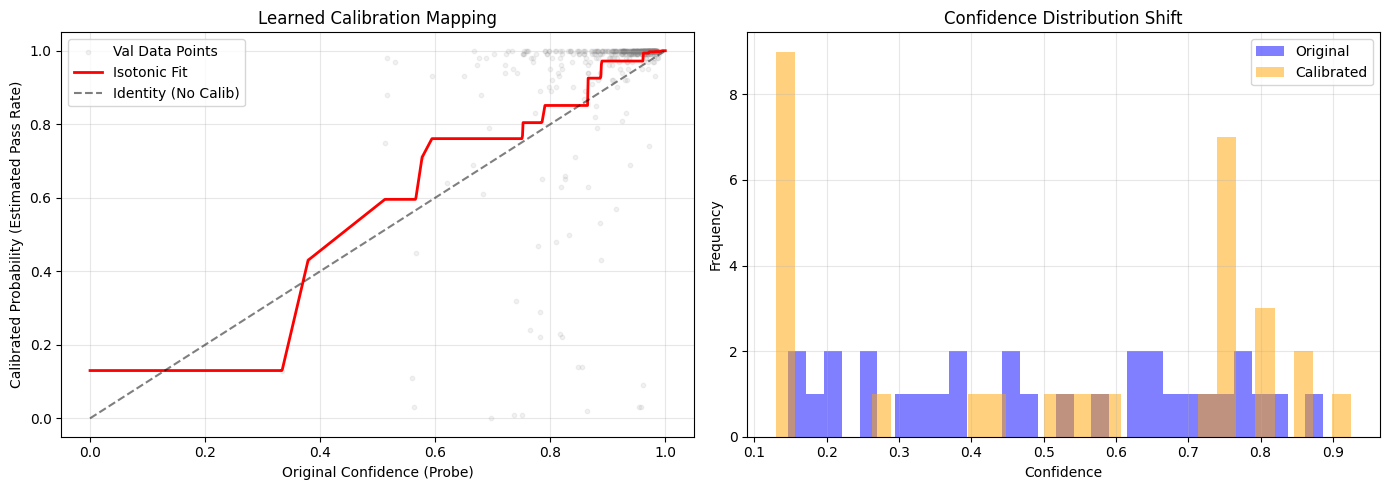

INFO: No scores were mapped to exactly 0.0


In [40]:
from sklearn.isotonic import IsotonicRegression
import matplotlib.pyplot as plt

print(f"\n{'='*100}")
print(f"CALIBRATION: Fitting Isotonic Regression using 'math-valid'")
print(f"{'='*100}\n")

# 1. Configuration for Validation Set
VALID_DATASET = "math-valid" # The dataset used for calibration
VALID_MODEL = MODEL          # Use the same model/probe settings as test
VALID_CONFIDENCE_CONFIG = confidence_config.copy() 

# 2. Find Validation Data Folder
valid_folders = []
for folder in OUTPUTS_DIR.iterdir():
    if folder.is_dir() and VALID_DATASET in folder.name and VALID_MODEL in folder.name:
        if 'k-200' in folder.name: continue
        valid_folders.append(folder)

if not valid_folders:
    print(f"⚠️ Warning: Could not find validation folder for {VALID_DATASET} + {VALID_MODEL}")
    print("Skipping calibration step. Using raw confidence.")
else:
    valid_folder_path = valid_folders[0]
    print(f"✓ Found validation folder: {valid_folder_path.name}")

    # 3. Load Validation Ground Truth & Confidence
    print("Loading validation data for calibration...")
    # Note: We load ALL validation samples to get the best fit
    val_ground_truth, _, val_ids = load_model_data(valid_folder_path, 1000) 
    
    val_confidence_map = load_confidence(
        VALID_CONFIDENCE_CONFIG,
        valid_folder_path,
        val_ground_truth,
        val_ids,
        ESTIMATOR_RESULTS_DIR
    )
    
    # Prepare Arrays for Scikit-Learn
    # X = Raw Confidence Scores, y = Actual Expected Accuracy (Ground Truth)
    X_val = []
    y_val = []
    
    for eid in val_ids:
        if eid in val_confidence_map:
            X_val.append(val_confidence_map[eid])
            y_val.append(val_ground_truth[eid])
            
    X_val = np.array(X_val)
    y_val = np.array(y_val)
    
    print(f"✓ Loaded {len(X_val)} validation pairs")

    # 4. Train Isotonic Regression
    # y_min=0, y_max=1 enforces probabilities stay within bounds
    # out_of_bounds='clip' handles test scores outside validation range
    iso_reg = IsotonicRegression(y_min=0, y_max=1, out_of_bounds='clip')
    iso_reg.fit(X_val, y_val)
    
    print("✓ Isotonic Regression fitted")

    # 5. Apply Calibration to TEST set
    # We must preserve the dictionary structure
    test_ids_list = list(confidence.keys())
    X_test_raw = np.array([confidence[eid] for eid in test_ids_list])
    
    # Transform test scores
    X_test_calibrated = iso_reg.predict(X_test_raw)
    
    # Overwrite the confidence dictionary with calibrated values
    confidence_original = confidence.copy() # Keep backup if needed for comparison
    confidence = {eid: float(prob) for eid, prob in zip(test_ids_list, X_test_calibrated)}
    
    print("✓ Applied calibration to test set confidence scores")

    # ---------------------------------------------------------
    # Visualization: The Calibration Effect
    # ---------------------------------------------------------
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: The Calibration Function
    # Sort X_val for a clean line plot
    sort_idx = np.argsort(X_val)
    ax1.scatter(X_val, y_val, alpha=0.1, color='gray', label='Val Data Points', s=10)
    # Plot the learned function
    # We create a smooth linspace to visualize the step function clearly
    x_grid = np.linspace(0, 1, 1000)
    ax1.plot(x_grid, iso_reg.predict(x_grid), color='red', linewidth=2, label='Isotonic Fit')
    ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Identity (No Calib)')
    ax1.set_xlabel('Original Confidence (Probe)')
    ax1.set_ylabel('Calibrated Probability (Estimated Pass Rate)')
    ax1.set_title(f'Learned Calibration Mapping')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Histogram Correction (The "Zero Spike" Fix)
    ax2.hist(X_test_raw, bins=30, alpha=0.5, label='Original', color='blue', density=False)
    ax2.hist(X_test_calibrated, bins=30, alpha=0.5, label='Calibrated', color='orange', density=False)
    ax2.set_xlabel('Confidence')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Confidence Distribution Shift')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show() 
    
    # Inspect the "Zero" threshold
    # Find the highest input score that gets mapped to 0 (or near zero)
    # This tells you the "hardness threshold" the model learned
    low_mask = iso_reg.predict(x_grid) <= 0.001
    if any(low_mask):
        zero_threshold = x_grid[low_mask].max()
        print(f"INFO: Confidence scores below {zero_threshold:.4f} are now mapped to ~0.0")
    else:
        print("INFO: No scores were mapped to exactly 0.0")

## 4.2 Quantile Mapping


CALIBRATION: Rank-Based Histogram Matching (Empirical Quantile Mapping)

✓ Found validation folder: math-valid__gpt-oss-20b__A40
Loading validation distribution...
grount_truth_path: ../outputs/math-valid__gpt-oss-20b__A40/ground_truth.jsonl
✓ Loaded target distribution from 500 validation examples
  - Zero-shot accuracy (approx): 0.9403
  - Proportion of 'Impossible' (0.0) tasks: 0.0020
✓ Applied Histogram Matching to test set


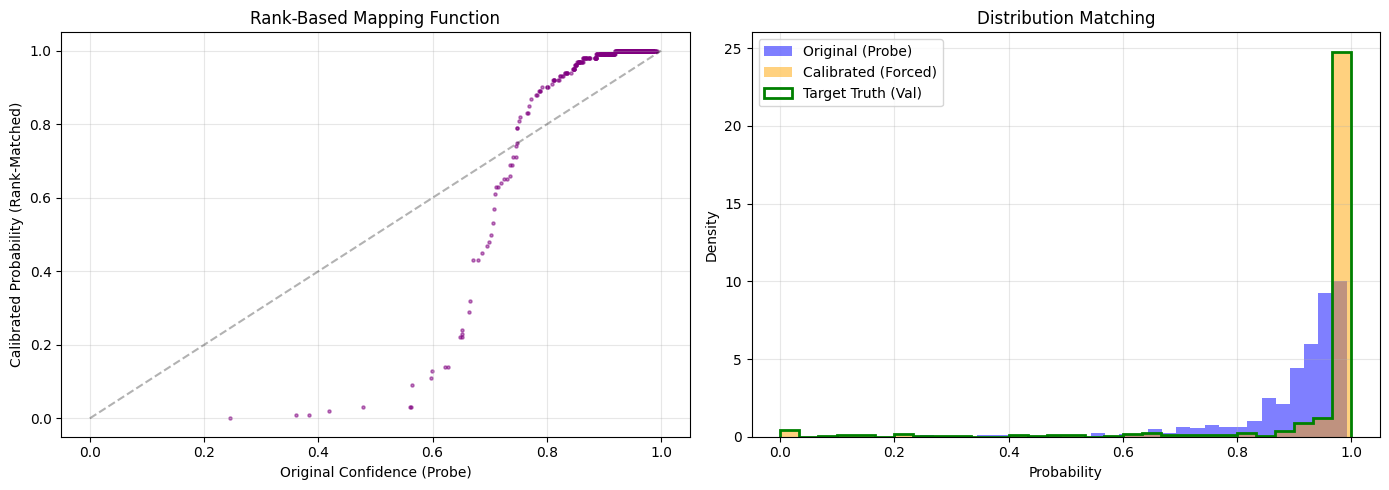

INFO: Exact Zeros in Confidence: 0 -> 1


In [54]:
import matplotlib.pyplot as plt
import numpy as np

print(f"\n{'='*100}")
print(f"CALIBRATION: Rank-Based Histogram Matching (Empirical Quantile Mapping)")
print(f"{'='*100}\n")

# 1. Configuration
VALID_DATASET = "math-valid"
VALID_MODEL = MODEL
VALID_CONFIDENCE_CONFIG = confidence_config.copy()

# 2. Find Validation Data
valid_folders = []
for folder in OUTPUTS_DIR.iterdir():
    if folder.is_dir() and VALID_DATASET in folder.name and VALID_MODEL in folder.name:
        if 'k-200' in folder.name: continue
        valid_folders.append(folder)

if not valid_folders:
    print(f"⚠️ Warning: Validation folder not found. Cannot perform Rank Calibration.")
else:
    valid_folder_path = valid_folders[0]
    print(f"✓ Found validation folder: {valid_folder_path.name}")

    # 3. Load Validation Ground Truth
    # We need the DISTRIBUTION of truths (e.g., lots of 0.0s, some 1.0s)
    print("Loading validation distribution...")
    val_ground_truth, _, val_ids = load_model_data(valid_folder_path, 1000)
    
    # Extract the target distribution we want to match
    target_distribution = np.array([val_ground_truth[eid] for eid in val_ids])
    
    print(f"✓ Loaded target distribution from {len(target_distribution)} validation examples")
    print(f"  - Zero-shot accuracy (approx): {np.mean(target_distribution):.4f}")
    print(f"  - Proportion of 'Impossible' (0.0) tasks: {np.mean(target_distribution == 0.0):.4f}")

    # 4. Apply Rank-Based Mapping to TEST set
    # Get test confidence scores
    test_ids = sorted(confidence.keys())
    test_conf_raw = np.array([confidence[eid] for eid in test_ids])
    
    # A. Get the Rank of each test sample (0 to 1 scale)
    # argsort().argsort() gives the rank index
    # We normalize by len to get a percentile (0.0 to 1.0)
    test_ranks = np.argsort(np.argsort(test_conf_raw)) / (len(test_conf_raw) - 1)
    
    # B. Map Ranks to Validation Quantiles
    # We find the value in the Validation Distribution at that percentile
    # np.quantile linearly interpolates the validation distribution to match test set size
    test_conf_calibrated = np.quantile(target_distribution, test_ranks, method='linear')
    
    # Update dictionary
    confidence_original = confidence.copy()
    confidence = {eid: float(prob) for eid, prob in zip(test_ids, test_conf_calibrated)}
    
    print("✓ Applied Histogram Matching to test set")

    # ---------------------------------------------------------
    # Visualization
    # ---------------------------------------------------------
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: The Mapping Function (What happened to the scores?)
    # X = Original Confidence, Y = New Calibrated Probability
    ax1 = axes[0]
    ax1.scatter(test_conf_raw, test_conf_calibrated, alpha=0.5, s=5, color='purple')
    ax1.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Identity')
    ax1.set_xlabel('Original Confidence (Probe)')
    ax1.set_ylabel('Calibrated Probability (Rank-Matched)')
    ax1.set_title('Rank-Based Mapping Function')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Histogram Comparison
    # This proves we fixed the distribution shape
    ax2 = axes[1]
    ax2.hist(test_conf_raw, bins=30, alpha=0.5, label='Original (Probe)', color='blue', density=True)
    ax2.hist(test_conf_calibrated, bins=30, alpha=0.5, label='Calibrated (Forced)', color='orange', density=True)
    # Overlay the actual validation truth to show the match
    ax2.hist(target_distribution, bins=30, histtype='step', linewidth=2, label='Target Truth (Val)', color='green', density=True)
    
    ax2.set_xlabel('Probability')
    ax2.set_ylabel('Density')
    ax2.set_title('Distribution Matching')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Check the "Zero" count
    zero_count_before = np.sum(test_conf_raw == 0.0)
    zero_count_after = np.sum(test_conf_calibrated == 0.0)
    print(f"INFO: Exact Zeros in Confidence: {zero_count_before} -> {zero_count_after}")


EXPERIMENTAL: Fitting Beta Distribution to Test Predictions

✓ Fitted Parameters: alpha = 11.4022, beta = 1.2188
  -> Result: Bell-Shaped (Warning: Did not find 'hard zeros')
✓ Replaced raw confidence with Beta-fitted values.


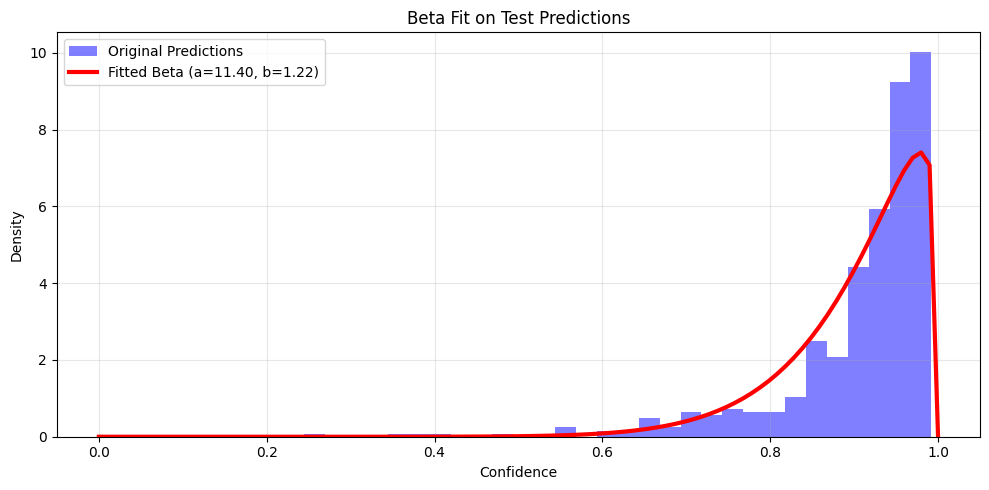

In [65]:
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt

print(f"\n{'='*100}")
print(f"EXPERIMENTAL: Fitting Beta Distribution to Test Predictions")
print(f"{'='*100}\n")

# 1. Extract Confidence Scores
test_conf_values = np.array(list(confidence.values()))

# Clip to avoid 0.0/1.0 errors during fitting (Beta is defined on (0, 1))
test_conf_clean = np.clip(test_conf_values, 1e-6, 1-1e-6)

# 2. Fit Beta Distribution
# We fix floc=0 and fscale=1 to force the range to be [0, 1]
# This finds the best alpha/beta that matches your Linear Probe's histogram
a_fit, b_fit, _, _ = beta.fit(test_conf_clean, floc=0, fscale=1)

print(f"✓ Fitted Parameters: alpha = {a_fit:.4f}, beta = {b_fit:.4f}")

# Analysis of the fit
if a_fit < 1 and b_fit < 1:
    print("  -> Result: U-Shaped (Good! Found the 'hard zeros' and 'easy ones')")
elif a_fit > 1 and b_fit > 1:
    print("  -> Result: Bell-Shaped (Warning: Did not find 'hard zeros')")
else:
    print("  -> Result: J-Shaped (Skewed)")

# 3. Generate "Beta-Smoothed" Confidence
# We simulate what the confidence WOULD be if it perfectly followed this fit.
# We generate N samples from the fitted Beta and map them to our test set (preserving rank).
fitted_distribution = beta.rvs(a_fit, b_fit, size=len(test_conf_values))
fitted_distribution = np.sort(fitted_distribution) # Sort for ranking

# Map to original IDs based on rank (Quantile Mapping to the Fitted Curve)
# This preserves the ordering of your probe but changes the values to fit the Beta curve.
sorted_indices = np.argsort(test_conf_values)
confidence_beta = {}

for rank, idx in enumerate(sorted_indices):
    eid = list(confidence.keys())[idx]
    confidence_beta[eid] = float(fitted_distribution[rank])

# 4. Update the main confidence dictionary for the simulation step
confidence_original = confidence.copy() # Backup
confidence = confidence_beta

print("✓ Replaced raw confidence with Beta-fitted values.")

# ---------------------------------------------------------
# Visualization: What did the fit do?
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 5))

# Plot Original Histogram
ax.hist(test_conf_values, bins=30, alpha=0.5, label='Original Predictions', density=True, color='blue')

# Plot the Fitted Beta Curve
x = np.linspace(0, 1, 100)
ax.plot(x, beta.pdf(x, a_fit, b_fit), 'r-', lw=3, label=f'Fitted Beta (a={a_fit:.2f}, b={b_fit:.2f})')

ax.set_title('Beta Fit on Test Predictions')
ax.set_xlabel('Confidence')
ax.set_ylabel('Density')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [66]:
print(confidence)

{'math500_test_94': 0.5631453775166494, 'math500_test_227': 0.5847385042593495, 'math500_test_281': 0.5913824067017128, 'math500_test_255': 0.6060526385235647, 'math500_test_219': 0.622213078344825, 'math500_test_264': 0.6412060621822372, 'math500_test_284': 0.6707248023087606, 'math500_test_103': 0.6754420525398163, 'math500_test_296': 0.6881844466416996, 'math500_test_295': 0.688964349207695, 'math500_test_96': 0.6974733563298415, 'math500_test_18': 0.7000986920495031, 'math500_test_168': 0.7060740082298889, 'math500_test_267': 0.7082467737236943, 'math500_test_188': 0.7085412618449931, 'math500_test_120': 0.7093887050244093, 'math500_test_396': 0.7097865190197126, 'math500_test_379': 0.7240599587980222, 'math500_test_372': 0.727885665436774, 'math500_test_228': 0.7297460431731475, 'math500_test_494': 0.7409163736464619, 'math500_test_444': 0.7416874637504361, 'math500_test_88': 0.744561467090575, 'math500_test_475': 0.7453724190535165, 'math500_test_136': 0.7498204838825306, 'math50

## 5. Simulate Pass@k

Compute simulated pass@k using confidence scores.

In [67]:
print("Simulating pass@k...")
simulated_results = simulate_passk(confidence, K_VALUES, example_ids)

print(f"\n✓ Simulated Pass@k Results:")
print(f"  K values: {simulated_results['k_values']}")
print(f"  Mean:     {[f'{x:.4f}' for x in simulated_results['mean']]}")

Simulating pass@k...

✓ Simulated Pass@k Results:
  K values: [1, 2, 4, 8, 16, 32, 48, 64]
  Mean:     ['0.9069', '0.9852', '0.9992', '1.0000', '1.0000', '1.0000', '1.0000', '1.0000']


## 6. Compute Actual Pass@k

Compute actual pass@k from sampled data.

In [68]:
print("Computing actual pass@k...")
actual_results = compute_actual_passk(samples, K_VALUES, example_ids)

print(f"\n✓ Actual Pass@k Results:")
print(f"  K values: {actual_results['k_values']}")
print(f"  Mean:     {[f'{x:.4f}' for x in actual_results['mean']]}")

Computing actual pass@k...

✓ Actual Pass@k Results:
  K values: [1, 2, 4, 8, 16, 32, 48, 64]
  Mean:     ['0.9319', '0.9593', '0.9731', '0.9815', '0.9867', '0.9904', '0.9920', '0.9929']


## 7. Per-Instance Analysis

View detailed results for individual instances.

In [69]:
# Select instances to display
display_ids = example_ids[:NUM_INSTANCES_TO_PRINT] if NUM_INSTANCES_TO_PRINT else example_ids

print(f"\n{'='*100}")
print(f"PER-INSTANCE ANALYSIS (showing {len(display_ids)} instances)")
print(f"{'='*100}\n")

for example_id in display_ids:
    conf = confidence.get(example_id, 0.0)
    expected_acc = ground_truth[example_id]
    
    print(f"Example ID: {example_id}")
    print(f"  Confidence (loaded):  {conf:.4f}")
    print(f"  Expected Acc (oracle): {expected_acc:.4f}")
    print(f"  Confidence Error:     {abs(conf - expected_acc):.4f}")
    
    # Compute per-instance pass@k
    if example_id in samples:
        sample_correctness = samples[example_id]
        print(f"  Available samples:    {len(sample_correctness)}")
        print(f"  Correct samples:      {sum(sample_correctness)} ({sum(sample_correctness)/len(sample_correctness)*100:.1f}%)")
        
        # Show simulated pass@k for this instance
        print(f"  Simulated Pass@k:")
        for k in K_VALUES[:5]:  # Show first 5 k values
            sim_passk = 1 - (1 - conf) ** k
            print(f"    k={k:3d}: {sim_passk:.4f}")
        print(f"  Real Pass@k:")
        for k in K_VALUES[:5]:  # Show first 5 k values  
            real_passk = pass_at_k(len(sample_correctness), sum(sample_correctness), k)
            print(f"    k={k:3d}: {real_passk:.4f}")
    
    print()


PER-INSTANCE ANALYSIS (showing 500 instances)

Example ID: math500_test_0
  Confidence (loaded):  0.9707
  Expected Acc (oracle): 1.0000
  Confidence Error:     0.0293
  Available samples:    100
  Correct samples:      100 (100.0%)
  Simulated Pass@k:
    k=  1: 0.9707
    k=  2: 0.9991
    k=  4: 1.0000
    k=  8: 1.0000
    k= 16: 1.0000
  Real Pass@k:
    k=  1: 1.0000
    k=  2: 1.0000
    k=  4: 1.0000
    k=  8: 1.0000
    k= 16: 1.0000

Example ID: math500_test_1
  Confidence (loaded):  0.9247
  Expected Acc (oracle): 1.0000
  Confidence Error:     0.0753
  Available samples:    100
  Correct samples:      100 (100.0%)
  Simulated Pass@k:
    k=  1: 0.9247
    k=  2: 0.9943
    k=  4: 1.0000
    k=  8: 1.0000
    k= 16: 1.0000
  Real Pass@k:
    k=  1: 1.0000
    k=  2: 1.0000
    k=  4: 1.0000
    k=  8: 1.0000
    k= 16: 1.0000

Example ID: math500_test_10
  Confidence (loaded):  0.8692
  Expected Acc (oracle): 0.9900
  Confidence Error:     0.1208
  Available samples:    10

## 8. Compare Simulated vs Actual Pass@k

In [70]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'k': K_VALUES,
    'Simulated': simulated_results['mean'],
    'Actual': actual_results['mean'],
    'Difference': np.array(simulated_results['mean']) - np.array(actual_results['mean'])
})

print(f"\n{'='*100}")
print(f"COMPARISON: Simulated vs Actual Pass@k")
print(f"{'='*100}\n")
print(comparison_df.to_string(index=False))

print(f"\nSummary:")
print(f"  Mean Absolute Error: {np.mean(np.abs(comparison_df['Difference'])):.4f}")
print(f"  Max Absolute Error:  {np.max(np.abs(comparison_df['Difference'])):.4f}")


COMPARISON: Simulated vs Actual Pass@k

 k  Simulated   Actual  Difference
 1   0.906875 0.931920   -0.025045
 2   0.985203 0.959276    0.025927
 4   0.999161 0.973138    0.026023
 8   0.999989 0.981451    0.018538
16   1.000000 0.986747    0.013253
32   1.000000 0.990424    0.009576
48   1.000000 0.992004    0.007996
64   1.000000 0.992917    0.007083

Summary:
  Mean Absolute Error: 0.0167
  Max Absolute Error:  0.0260


## 9. Visualizations

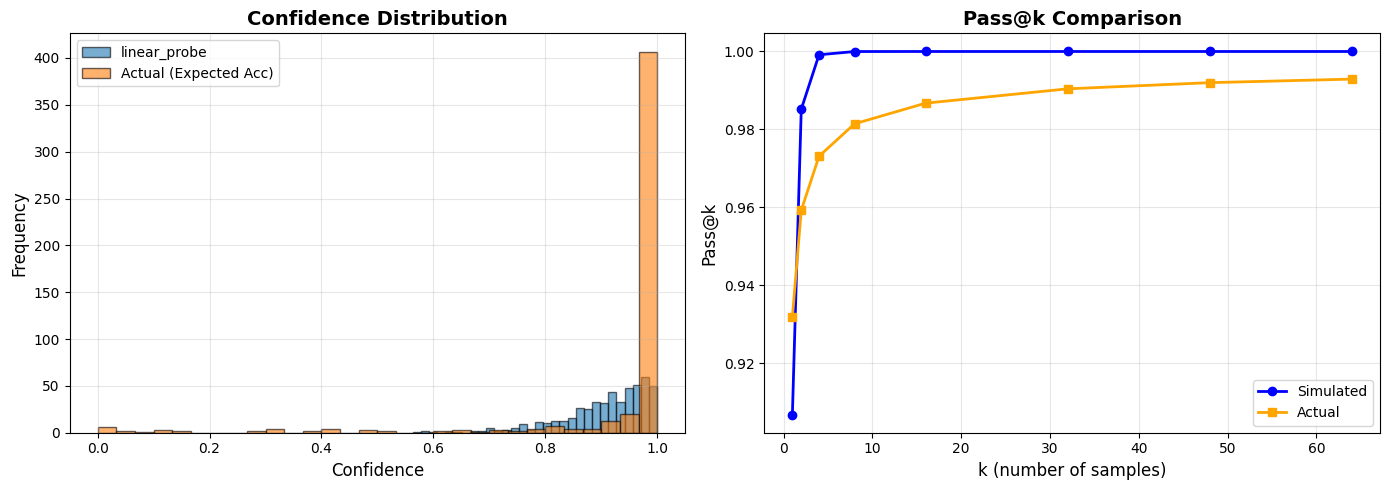

✓ Plots generated


In [71]:
# Plot 1: Confidence distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confidence histogram
ax = axes[0]
conf_values = list(confidence.values())
oracle_values = [ground_truth[eid] for eid in example_ids]

ax.hist(conf_values, bins=30, alpha=0.6, label=CONFIDENCE_METHOD, edgecolor='black')
ax.hist(oracle_values, bins=30, alpha=0.6, label='Actual (Expected Acc)', edgecolor='black')
ax.set_xlabel('Confidence', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Confidence Distribution', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Pass@k comparison
ax = axes[1]
ax.plot(K_VALUES, simulated_results['mean'], marker='o', linewidth=2, 
        label='Simulated', color='blue', markersize=6)
ax.plot(K_VALUES, actual_results['mean'], marker='s', linewidth=2,
        label='Actual', color='orange', markersize=6)

ax.set_xlabel('k (number of samples)', fontsize=12)
ax.set_ylabel('Pass@k', fontsize=12)
#ax.set_yticks([0.5, 0.7, 0.9])
ax.set_title('Pass@k Comparison', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Plots generated")

## 10. Confidence Error Analysis

Analyze the error between loaded confidence and oracle confidence.

In [72]:
from scipy import stats


CONFIDENCE ERROR ANALYSIS

Error Statistics:
  Mean Squared Error (Brier):    0.0279
  Mean Absolute Error:  0.1004
  Spearman: 0.5649

Worst predictions (highest absolute error):
      example_id  confidence  oracle    error
 math500_test_23    0.909808    0.00 0.827750
math500_test_154    0.844652    0.00 0.713437
math500_test_400    0.832202    0.00 0.692560
math500_test_308    0.837936    0.05 0.620843
math500_test_240    0.800067    0.02 0.608504
 math500_test_25    0.786132    0.01 0.602381
 math500_test_67    0.851281    0.14 0.505921
math500_test_383    0.959338    0.27 0.475187
math500_test_204    0.768437    0.08 0.473945
math500_test_422    0.788431    0.13 0.433531


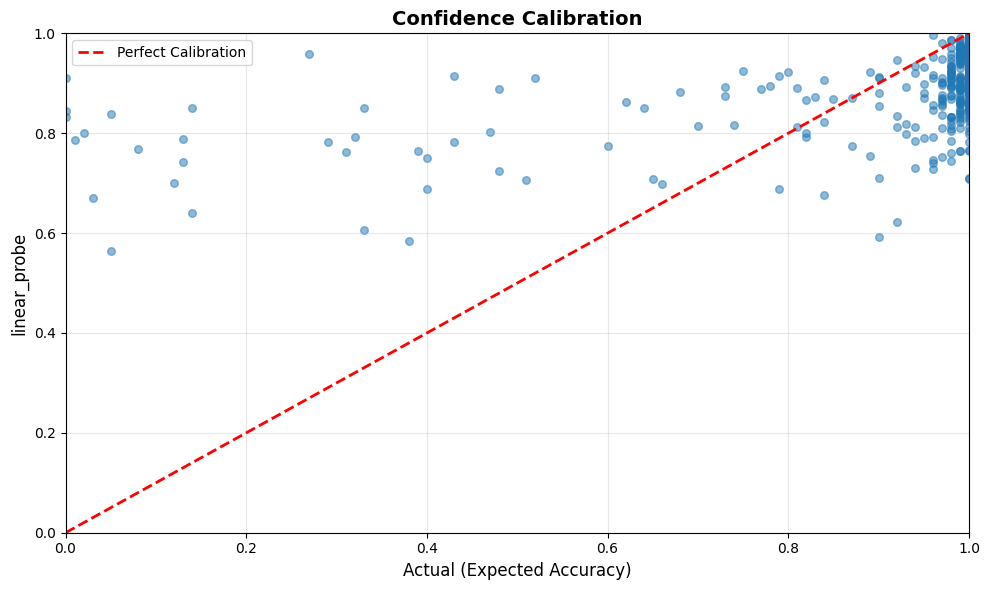

In [73]:
# Compute confidence errors
errors = []
for eid in example_ids:
    conf = confidence.get(eid, 0.0)
    oracle = ground_truth[eid]
    errors.append({
        'example_id': eid,
        'confidence': conf,
        'oracle': oracle,
        'error': (conf - oracle)*(conf - oracle),
        'abs_error': abs(conf - oracle)
    })

errors_df = pd.DataFrame(errors)

spearman_corr = stats.spearmanr(errors_df['oracle'],errors_df['confidence'])
print(f"\n{'='*100}")
print(f"CONFIDENCE ERROR ANALYSIS")
print(f"{'='*100}\n")

print(f"Error Statistics:")
print(f"  Mean Squared Error (Brier):    {errors_df['error'].mean():.4f}")
print(f"  Mean Absolute Error:  {errors_df['abs_error'].mean():.4f}")

print(f"  Spearman: {spearman_corr.statistic:.4f}")

print(f"\nWorst predictions (highest absolute error):")
print(errors_df.nlargest(10, 'abs_error')[['example_id', 'confidence', 'oracle', 'error']].to_string(index=False))

# Plot error distribution
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(errors_df['oracle'], errors_df['confidence'], alpha=0.5, s=30)
ax.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect Calibration')
ax.set_xlabel('Actual (Expected Accuracy)', fontsize=12)
ax.set_ylabel(CONFIDENCE_METHOD, fontsize=12)
ax.set_title('Confidence Calibration', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
plt.tight_layout()
plt.show()